In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calculations

In [2]:
# define time horizon
t0 = 2025
t_midH = 2035 # hydrogen start
t_midE = 2040 # electric start
t_end = 2050
years = np.arange(t0, t_end + 1)

# modal‐share endpoints
share_BF_0 = 0.003
share_BF_end = 0.20
share_H_0 = 0.0
share_H_end = 0.18
share_E_0 = 0.0
share_E_end = 0.02

# emissions and energy constants
intensity = {
    'JF': 0.07721, # kg CO2e/MJ
    'BF': 0.038,
    'H' : 0.00525,
    'E' : 0.0
}
energy_vkm = {
    'JF': 124.02, # MJ/Vkm
    'BF': 124.02,
    'H' : 56.8,
    'E' :  0.0 # no emissions if intensity zero
}

# total Vkm and population interpolation
Vkm_tot = (124.02)**(-1) * (43.02 * 338.1e9 + 43.6 * 1.017e9)
pop_start = 8.162e9
pop_end = 9.8e9
population = np.linspace(pop_start, pop_end, len(years))

# build DataFrame
df = pd.DataFrame({'year': years, 'population': population})

def lin_interp(t, t0, t1, x0, x1):
    return x0 + (x1 - x0) * (t - t0) / (t1 - t0)

# modal shares
df['share_BF'] = lin_interp(df['year'], t0, t_end, share_BF_0, share_BF_end)
df['share_H']  = df['year'].apply(lambda yr:
    share_H_0 if yr <= t_midH
    else lin_interp(yr, t_midH, t_end, share_H_0, share_H_end)
)
df['share_E']  = df['year'].apply(lambda yr:
    share_E_0 if yr <= t_midE
    else lin_interp(yr, t_midE, t_end, share_E_0, share_E_end)
)
df['share_JF'] = 1.0 - df['share_BF'] - df['share_H'] - df['share_E']

# per-fuel CO2e per Vkm and total CO2e
for mode in ['JF','BF','H']:
    df[f'CO2e_per_Vkm_{mode}'] = intensity[mode] * energy_vkm[mode] * df[f'share_{mode}']
    df[f'CO2e_total_{mode}']   = df[f'CO2e_per_Vkm_{mode}'] * Vkm_tot
    df[f'CO2e_pc_{mode}']      = df[f'CO2e_total_{mode}']   / df['population']

# aggregate metrics
df['CO2e_total'] = df[['CO2e_total_JF','CO2e_total_BF','CO2e_total_H']].sum(axis=1)
df['CO2e_per_capita'] = df['CO2e_total'] / df['population']
df['CO2e_per_Vkm'] = df['CO2e_total'] / Vkm_tot

# comparison to when no technology has advanced
fixed_em_per_vkm = (
    intensity['JF'] * energy_vkm['JF'] * (1 - share_BF_0) +
    intensity['BF'] * energy_vkm['BF'] * share_BF_0
)
CO2e_target_2050 = df.loc[df.year == t_end, 'CO2e_total'].iloc[0]
Vkm_needed = CO2e_target_2050 / fixed_em_per_vkm

CO2e_target_2025 = df.loc[df.year == t0, 'CO2e_total'].iloc[0]

print(f"\n2050 CO₂e target = {CO2e_target_2050:.2e} kg")
print(f"\n2025 CO₂e target = {CO2e_target_2025:.2e} kg")


print(f"Absolute reduction: {CO2e_target_2025 - CO2e_target_2050:.2e}kg")
print(f"% reduction: {(1 - CO2e_target_2050/CO2e_target_2025)*100:.1f}%")


print(f"\nRequired Vkm no H/E: {Vkm_needed:.2e} km")
print(f"Vkm reduction needed: {(1 - Vkm_needed/Vkm_tot)*100:.1f}%")


2050 CO₂e target = 7.93e+11 kg

2025 CO₂e target = 1.12e+12 kg
Absolute reduction: 3.32e+11kg
% reduction: 29.5%

Required Vkm no H/E: 8.29e+10 km
Vkm reduction needed: 29.5%


In [3]:
df

,year,population,share_BF,share_H,share_E,share_JF,CO2e_per_Vkm_JF,CO2e_total_JF,CO2e_pc_JF,CO2e_per_Vkm_BF,CO2e_total_BF,CO2e_pc_BF,CO2e_per_Vkm_H,CO2e_total_H,CO2e_pc_H,CO2e_total,CO2e_per_capita,CO2e_per_Vkm
0,2025,8.162000e+09,0.00300,0.000,0.000,0.99700,9.546857,1.123068e+12,137.597216,0.014138,1.663192e+09,0.203773,0.000000,0.000000e+00,0.000000,1.124732e+12,137.800989,9.560996
1,2026,8.227520e+09,0.01088,0.000,0.000,0.98912,9.471402,1.114192e+12,135.422590,0.051275,6.031843e+09,0.733130,0.000000,0.000000e+00,0.000000,1.120224e+12,136.155720,9.522677
2,2027,8.293040e+09,0.01876,0.000,0.000,0.98124,9.395946,1.105316e+12,133.282326,0.088411,1.040049e+10,1.254123,0.000000,0.000000e+00,0.000000,1.115716e+12,134.536449,9.484358
3,2028,8.358560e+09,0.02664,0.000,0.000,0.97336,9.320491,1.096439e+12,131.175615,0.125548,1.476914e+10,1.766948,0.000000,0.000000e+00,0.000000,1.111208e+12,132.942564,9.446039
4,2029,8.424080e+09,0.03452,0.000,0.000,0.96548,9.245035,1.087563e+12,129.101675,0.162684,1.913780e+10,2.271797,0.000000,0.000000e+00,0.000000,1.106701e+12,131.373472,9.407720
5,2030,8.489600e+09,0.04240,0.000,0.000,0.95760,9.169579,1.078686e+12,127.059748,0.199821,2.350645e+10,2.768852,0.000000,0.000000e+00,0.000000,1.102193e+12,129.828600,9.369400
6,2031,8.555120e+09,0.05028,0.000,0.000,0.94972,9.094124,1.069810e+12,125.049096,0.236958,2.787510e+10,3.258294,0.000000,0.000000e+00,0.000000,1.097685e+12,128.307390,9.331081
7,2032,8.620640e+09,0.05816,0.000,0.000,0.94184,9.018668,1.060934e+12,123.069008,0.274094,3.224375e+10,3.740296,0.000000,0.000000e+00,0.000000,1.093177e+12,126.809305,9.292762
8,2033,8.686160e+09,0.06604,0.000,0.000,0.93396,8.943213,1.052057e+12,121.118792,0.311231,3.661240e+10,4.215027,0.000000,0.000000e+00,0.000000,1.088670e+12,125.333819,9.254443
9,2034,8.751680e+09,0.07392,0.000,0.000,0.92608,8.867757,1.043181e+12,119.197777,0.348367,4.098105e+10,4.682650,0.000000,0.000000e+00,0.000000,1.084162e+12,123.880426,9.216124


In [4]:
summary_df = df[df['year'].isin([2025, 2050])][
    ['year', 'CO2e_total', 'CO2e_per_Vkm', 'CO2e_per_capita']
].copy()

summary_df.columns = ['Year', 'Total CO$_2$e (kg)', 'CO$_2$e per Vkm (kg)', 'CO$_2$e per capita (kg)']

summary_df = summary_df.round({
    'Total CO$_2$e (kg)': 2,
    'CO$_2$e per Vkm (kg)': 4,
    'CO$_2$e per capita (kg)': 2
})

latex_table = summary_df.to_latex(
    index=False,
    float_format="%.2e",
    caption="Comparison of CO$_2$ emissions in 2025 and 2050",
    label="tab:co2_summary",
    escape=False,
    longtable=False
)

print(latex_table)
summary_df

\begin{table}
\caption{Comparison of CO$_2$ emissions in 2025 and 2050}
\label{tab:co2_summary}
\begin{tabular}{rrrr}
\toprule
Year & Total CO$_2$e (kg) & CO$_2$e per Vkm (kg) & CO$_2$e per capita (kg) \\
\midrule
2025 & 1.12e+12 & 9.56e+00 & 1.38e+02 \\
2050 & 7.93e+11 & 6.74e+00 & 8.09e+01 \\
\bottomrule
\end{tabular}
\end{table}



,Year,Total CO$_2$e (kg),CO$_2$e per Vkm (kg),CO$_2$e per capita (kg)
0,2025,1.124732e+12,9.5610,137.80
25,2050,7.930625e+11,6.7416,80.92


# Relevant Plots

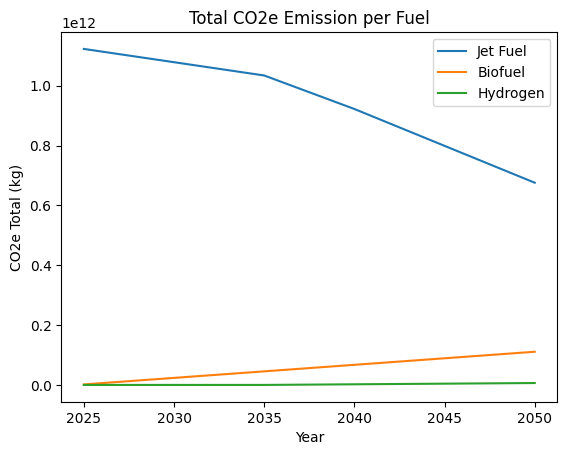

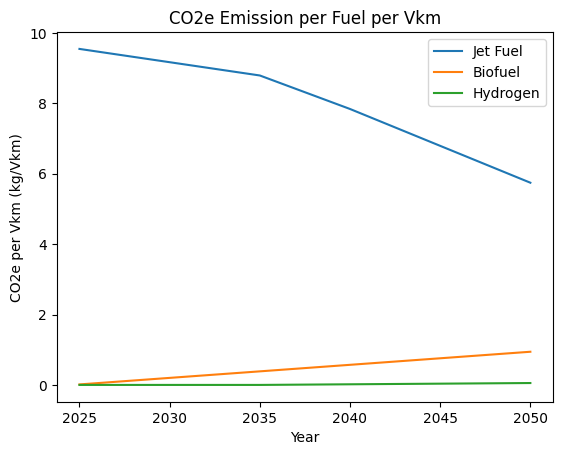

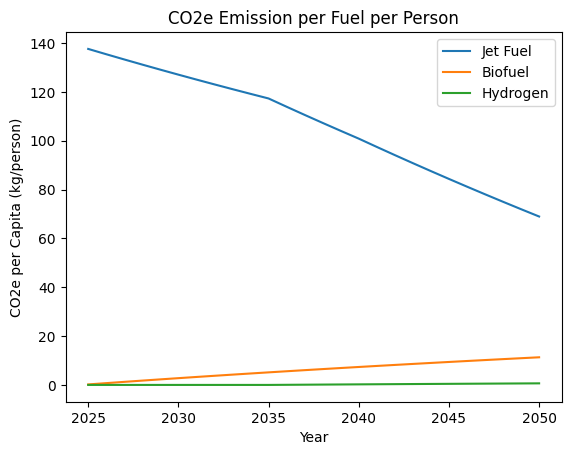

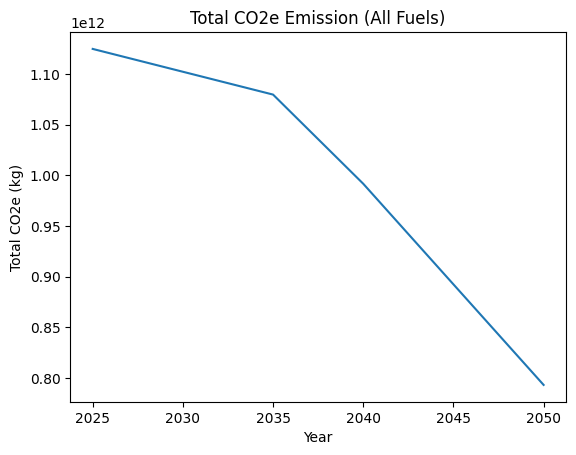

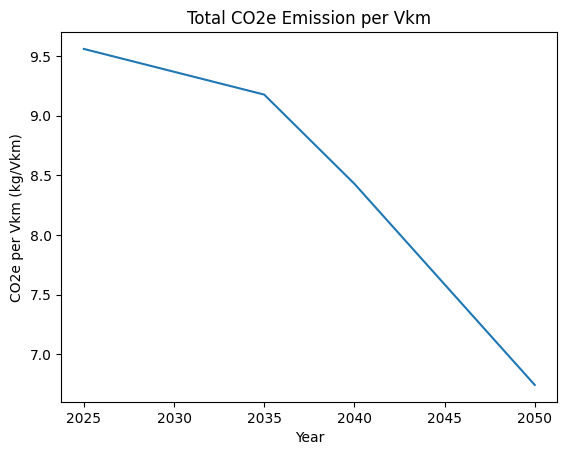

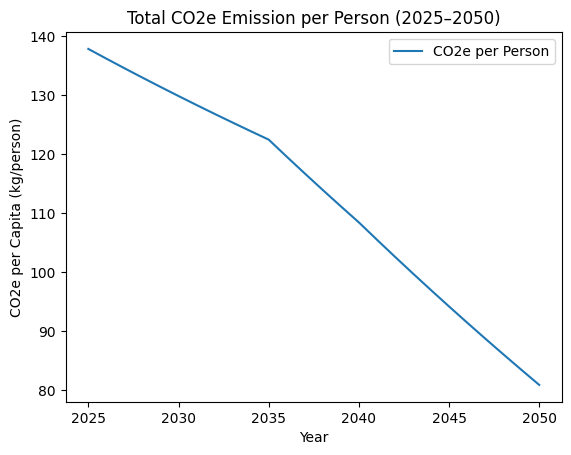

In [5]:
# Total CO2e emission per fuel (JF, BF, H)
plt.figure()
plt.plot(df['year'], df['CO2e_total_JF'], label='Jet Fuel')
plt.plot(df['year'], df['CO2e_total_BF'], label='Biofuel')
plt.plot(df['year'], df['CO2e_total_H'], label='Hydrogen')
plt.xlabel('Year')
plt.ylabel('CO2e Total (kg)')
plt.title('Total CO2e Emission per Fuel')
plt.legend()

# CO2e emission per fuel per Vkm
plt.figure()
plt.plot(df['year'], df['CO2e_per_Vkm_JF'], label='Jet Fuel')
plt.plot(df['year'], df['CO2e_per_Vkm_BF'], label='Biofuel')
plt.plot(df['year'], df['CO2e_per_Vkm_H'], label='Hydrogen')
plt.xlabel('Year')
plt.ylabel('CO2e per Vkm (kg/Vkm)')
plt.title('CO2e Emission per Fuel per Vkm')
plt.legend()

# CO2e emission per fuel per person
plt.figure()
plt.plot(df['year'], df['CO2e_pc_JF'], label='Jet Fuel')
plt.plot(df['year'], df['CO2e_pc_BF'], label='Biofuel')
plt.plot(df['year'], df['CO2e_pc_H'], label='Hydrogen')
plt.xlabel('Year')
plt.ylabel('CO2e per Capita (kg/person)')
plt.title('CO2e Emission per Fuel per Person')
plt.legend()

# Total CO2e emission (all fuels)
plt.figure()
plt.plot(df['year'], df['CO2e_total'])
plt.xlabel('Year')
plt.ylabel('Total CO2e (kg)')
plt.title('Total CO2e Emission (All Fuels)')

# CO2e per Vkm overall
plt.figure()
plt.plot(df['year'], df['CO2e_per_Vkm'])
plt.xlabel('Year')
plt.ylabel('CO2e per Vkm (kg/Vkm)')
plt.title('Total CO2e Emission per Vkm')

plt.figure()
plt.plot(df['year'], df['CO2e_per_capita'], label='CO2e per Person')
plt.xlabel('Year')
plt.ylabel('CO2e per Capita (kg/person)')
plt.title('Total CO2e Emission per Person (2025–2050)')
plt.legend()
plt.show()

plt.show()

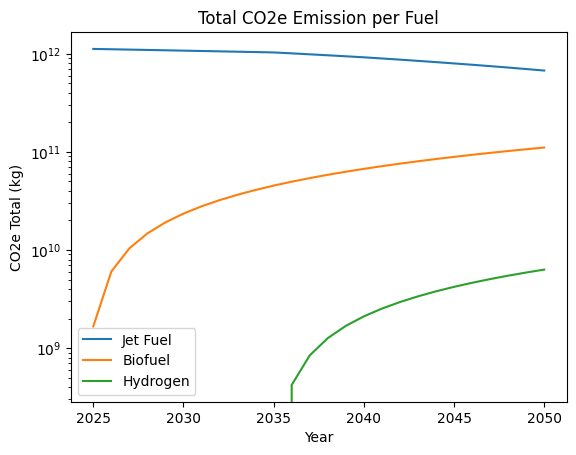

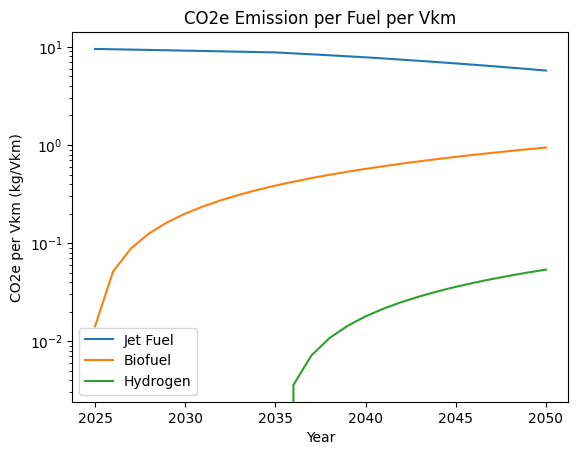

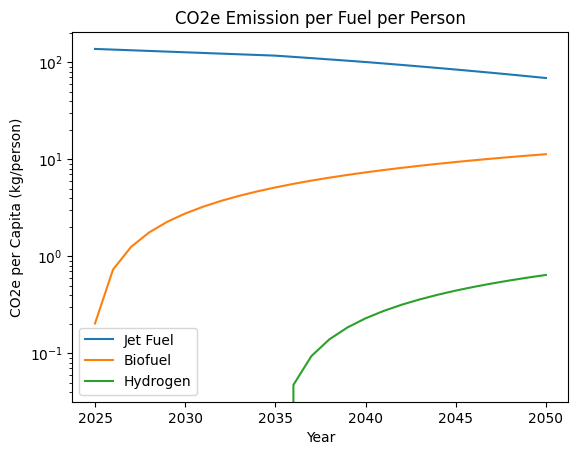

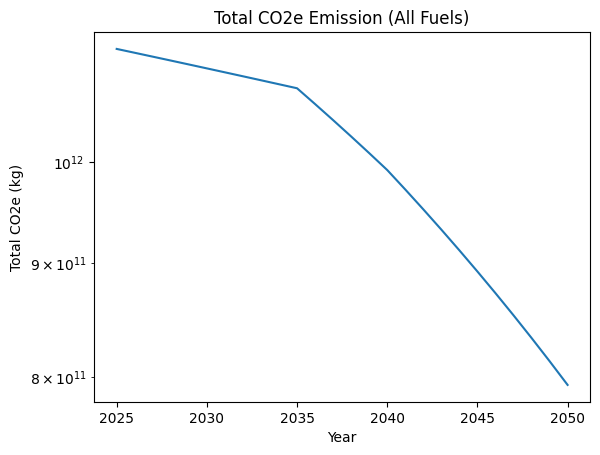

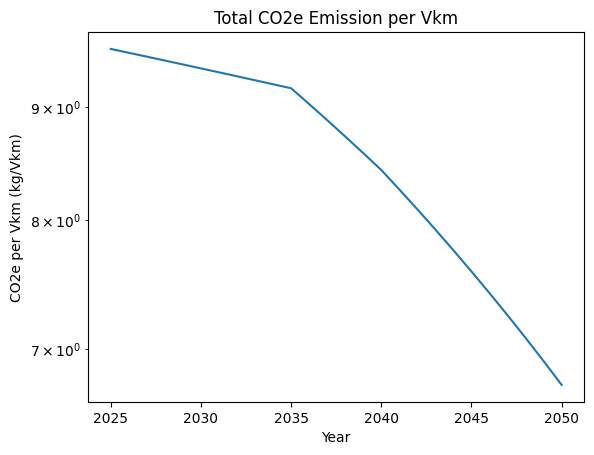

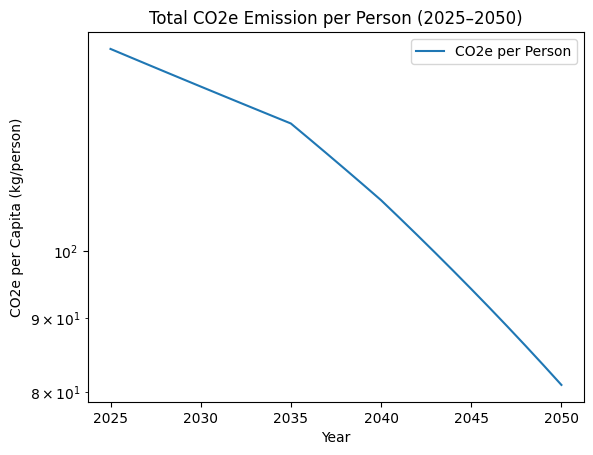

In [6]:
# Total CO2e emission per fuel (JF, BF, H)
plt.figure()
plt.plot(df['year'], df['CO2e_total_JF'], label='Jet Fuel')
plt.plot(df['year'], df['CO2e_total_BF'], label='Biofuel')
plt.plot(df['year'], df['CO2e_total_H'], label='Hydrogen')
plt.xlabel('Year')
plt.ylabel('CO2e Total (kg)')
plt.title('Total CO2e Emission per Fuel')
plt.yscale('log')
plt.legend()

# CO2e emission per fuel per Vkm
plt.figure()
plt.plot(df['year'], df['CO2e_per_Vkm_JF'], label='Jet Fuel')
plt.plot(df['year'], df['CO2e_per_Vkm_BF'], label='Biofuel')
plt.plot(df['year'], df['CO2e_per_Vkm_H'], label='Hydrogen')
plt.xlabel('Year')
plt.ylabel('CO2e per Vkm (kg/Vkm)')
plt.title('CO2e Emission per Fuel per Vkm')
plt.yscale('log')
plt.legend()

# CO2e emission per fuel per person
plt.figure()
plt.plot(df['year'], df['CO2e_pc_JF'], label='Jet Fuel')
plt.plot(df['year'], df['CO2e_pc_BF'], label='Biofuel')
plt.plot(df['year'], df['CO2e_pc_H'], label='Hydrogen')
plt.xlabel('Year')
plt.ylabel('CO2e per Capita (kg/person)')
plt.title('CO2e Emission per Fuel per Person')
plt.yscale('log')
plt.legend()

# Total CO2e emission (all fuels)
plt.figure()
plt.plot(df['year'], df['CO2e_total'])
plt.xlabel('Year')
plt.ylabel('Total CO2e (kg)')
plt.title('Total CO2e Emission (All Fuels)')
plt.yscale('log')

# CO2e per Vkm overall
plt.figure()
plt.plot(df['year'], df['CO2e_per_Vkm'])
plt.xlabel('Year')
plt.ylabel('CO2e per Vkm (kg/Vkm)')
plt.title('Total CO2e Emission per Vkm')
plt.yscale('log')

# CO2e per capita
plt.figure()
plt.plot(df['year'], df['CO2e_per_capita'], label='CO2e per Person')
plt.xlabel('Year')
plt.ylabel('CO2e per Capita (kg/person)')
plt.title('Total CO2e Emission per Person (2025–2050)')
plt.yscale('log')
plt.legend()

plt.show()

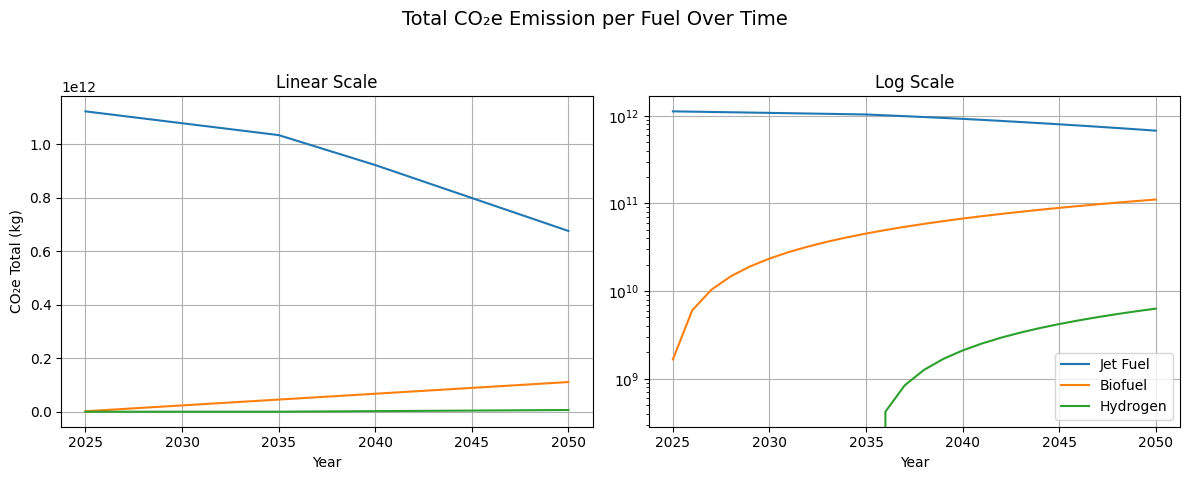

In [7]:
# 2 plots in 1 figure
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

axs[0].plot(df['year'], df['CO2e_total_JF'], label='Jet Fuel')
axs[0].plot(df['year'], df['CO2e_total_BF'], label='Biofuel')
axs[0].plot(df['year'], df['CO2e_total_H'], label='Hydrogen')
axs[0].set_title('Linear Scale')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('CO₂e Total (kg)')
axs[0].grid(True)

axs[1].plot(df['year'], df['CO2e_total_JF'], label='Jet Fuel')
axs[1].plot(df['year'], df['CO2e_total_BF'], label='Biofuel')
axs[1].plot(df['year'], df['CO2e_total_H'], label='Hydrogen')
axs[1].set_title('Log Scale')
axs[1].set_xlabel('Year')
axs[1].set_yscale('log')
axs[1].legend()
axs[1].grid(True)

fig.suptitle('Total CO₂e Emission per Fuel Over Time', fontsize=14)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig('co2e_emissions_comparison.png', dpi=300)
plt.show()

# Stranded Assets

In [8]:
fleet_size = 28400
avg_cost = 100e6 # USD per aircraft
# economic_life = 25

# total kerosene‐capable share (jet fuel + biofuel)
df['share_ker'] = df['share_JF'] + df['share_BF']

# stranded planes: drop in kerosene‐share * fleet
df['stranded_planes'] = df['share_ker'].shift(1).fillna(df['share_ker']).sub(df['share_ker']).clip(lower=0) * fleet_size

# assume uniform age distribution = avg remaining life = economic_life/2
rem_life_frac = 0.5

# economic loss in each year
df['econ_loss_year'] = df['stranded_planes'] * avg_cost * rem_life_frac

# cumulative economic loss
df['cum_econ_loss']  = df['econ_loss_year'].cumsum()

total_loss = df.loc[df['year'] == t_end, 'cum_econ_loss'].iloc[0]
print(f"By {t_end}, cumulative stranded-asset loss is USD {total_loss/1e9:.1f} billion")

By 2050, cumulative stranded-asset loss is USD 284.0 billion


In [9]:
df

,year,population,share_BF,share_H,share_E,share_JF,CO2e_per_Vkm_JF,CO2e_total_JF,CO2e_pc_JF,CO2e_per_Vkm_BF,...,CO2e_per_Vkm_H,CO2e_total_H,CO2e_pc_H,CO2e_total,CO2e_per_capita,CO2e_per_Vkm,share_ker,stranded_planes,econ_loss_year,cum_econ_loss
0,2025,8.162000e+09,0.00300,0.000,0.000,0.99700,9.546857,1.123068e+12,137.597216,0.014138,...,0.000000,0.000000e+00,0.000000,1.124732e+12,137.800989,9.560996,1.000,0.0,0.000000e+00,0.000000e+00
1,2026,8.227520e+09,0.01088,0.000,0.000,0.98912,9.471402,1.114192e+12,135.422590,0.051275,...,0.000000,0.000000e+00,0.000000,1.120224e+12,136.155720,9.522677,1.000,0.0,0.000000e+00,0.000000e+00
2,2027,8.293040e+09,0.01876,0.000,0.000,0.98124,9.395946,1.105316e+12,133.282326,0.088411,...,0.000000,0.000000e+00,0.000000,1.115716e+12,134.536449,9.484358,1.000,0.0,0.000000e+00,0.000000e+00
3,2028,8.358560e+09,0.02664,0.000,0.000,0.97336,9.320491,1.096439e+12,131.175615,0.125548,...,0.000000,0.000000e+00,0.000000,1.111208e+12,132.942564,9.446039,1.000,0.0,0.000000e+00,0.000000e+00
4,2029,8.424080e+09,0.03452,0.000,0.000,0.96548,9.245035,1.087563e+12,129.101675,0.162684,...,0.000000,0.000000e+00,0.000000,1.106701e+12,131.373472,9.407720,1.000,0.0,0.000000e+00,0.000000e+00
5,2030,8.489600e+09,0.04240,0.000,0.000,0.95760,9.169579,1.078686e+12,127.059748,0.199821,...,0.000000,0.000000e+00,0.000000,1.102193e+12,129.828600,9.369400,1.000,0.0,0.000000e+00,0.000000e+00
6,2031,8.555120e+09,0.05028,0.000,0.000,0.94972,9.094124,1.069810e+12,125.049096,0.236958,...,0.000000,0.000000e+00,0.000000,1.097685e+12,128.307390,9.331081,1.000,0.0,0.000000e+00,0.000000e+00
7,2032,8.620640e+09,0.05816,0.000,0.000,0.94184,9.018668,1.060934e+12,123.069008,0.274094,...,0.000000,0.000000e+00,0.000000,1.093177e+12,126.809305,9.292762,1.000,0.0,0.000000e+00,0.000000e+00
8,2033,8.686160e+09,0.06604,0.000,0.000,0.93396,8.943213,1.052057e+12,121.118792,0.311231,...,0.000000,0.000000e+00,0.000000,1.088670e+12,125.333819,9.254443,1.000,0.0,0.000000e+00,0.000000e+00
9,2034,8.751680e+09,0.07392,0.000,0.000,0.92608,8.867757,1.043181e+12,119.197777,0.348367,...,0.000000,0.000000e+00,0.000000,1.084162e+12,123.880426,9.216124,1.000,0.0,0.000000e+00,0.000000e+00
